# new draft

In [ ]:
pip install Sastrawi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 1.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.feature_extraction.text import TfidfVectorizer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
from geopy.distance import geodesic


tv = TfidfVectorizer(max_features=5000)
stem = StemmerFactory().create_stemmer()
stopword = StopWordRemoverFactory().create_stop_word_remover()

user_rating_data = pd.read_excel('https://github.com/WayGo12/WayGoApp/raw/main/WayGo-ML/dataset/user_rating_dataset.xlsx')
places_data = pd.read_excel('https://github.com/WayGo12/WayGoApp/raw/main/WayGo-ML/dataset/places_dataset.xlsx')
user_data = pd.read_excel('https://github.com/WayGo12/WayGoApp/raw/main/WayGo-ML/dataset/user_id_dataset.xlsx')

data_recommend = pd.merge(user_rating_data.groupby('Place_ID')['Place_Rating'].mean(), places_data, on='Place_ID')
data_copy1 = data_recommend.copy()

def prepare_data(user_rating_data):
    data_collaborative_filtering = user_rating_data.copy()

    global user_to_user_encoded, user_encoded_to_user, resto_to_resto_encoded, resto_encoded_to_resto

    user_ids = data_collaborative_filtering['ID_user'].unique().tolist()
    user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
    user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}

    resto_ids = data_collaborative_filtering['Place_ID'].unique().tolist()
    resto_to_resto_encoded = {x: i for i, x in enumerate(resto_ids)}
    resto_encoded_to_resto = {i: x for i, x in enumerate(resto_ids)}


    data_collaborative_filtering['user'] = data_collaborative_filtering['ID_user'].map(user_to_user_encoded)
    data_collaborative_filtering['place'] = data_collaborative_filtering['Place_ID'].map(resto_to_resto_encoded)

    num_users = len(user_to_user_encoded)
    num_resto = len(resto_encoded_to_resto)
    data_collaborative_filtering['Place_Rating'] = data_collaborative_filtering['Place_Rating'].values.astype(np.float32)
    min_rating = min(data_collaborative_filtering['Place_Rating'])
    max_rating = max(data_collaborative_filtering['Place_Rating'])

    data_collaborative_filtering = data_collaborative_filtering.sample(frac=1, random_state=42)

    x = data_collaborative_filtering[['user', 'place']].values
    y = data_collaborative_filtering['Place_Rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
    train_indices = int(0.8 * data_collaborative_filtering.shape[0])
    x_train, x_val, y_train, y_val = (
        x[:train_indices],
        x[train_indices:],
        y[:train_indices],
        y[train_indices:]
    )

    return x_train, x_val, y_train, y_val, num_users, num_resto, user_to_user_encoded, user_encoded_to_user, resto_to_resto_encoded, resto_encoded_to_resto


def create_model(num_users, num_resto, embedding_size):
    class RecommenderNet(tf.keras.Model):
        def __init__(self, num_users, num_resto, embedding_size, **kwargs):
            super(RecommenderNet, self).__init__(**kwargs)
            self.num_users = num_users
            self.num_resto = num_resto
            self.embedding_size = embedding_size
            self.user_embedding = layers.Embedding(
                num_users,
                embedding_size,
                embeddings_initializer='he_normal',
                embeddings_regularizer=keras.regularizers.l2(1e-6)
            )
            self.user_bias = layers.Embedding(num_users, 1)
            self.resto_embedding = layers.Embedding(
                num_resto,
                embedding_size,
                embeddings_initializer='he_normal',
                embeddings_regularizer=keras.regularizers.l2(1e-6)
            )
            self.resto_bias = layers.Embedding(num_resto, 1)

        def call(self, inputs):
            user_vector = self.user_embedding(inputs[:, 0])
            user_bias = self.user_bias(inputs[:, 0])
            resto_vector = self.resto_embedding(inputs[:, 1])
            resto_bias = self.resto_bias(inputs[:, 1])

            dot_user_resto = tf.tensordot(user_vector, resto_vector, 2)

            x = dot_user_resto + user_bias + resto_bias
            return tf.nn.sigmoid(x)

    model = RecommenderNet(num_users, num_resto, embedding_size)
    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )

    return model


def train_model(model, x_train, y_train, x_val, y_val, batch_size, epochs):
    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_val, y_val)
    )

    # Get the final accuracy from the history
    final_accuracy = history.history['val_root_mean_squared_error'][-1]

    return history, final_accuracy


def collaborative_filtering_recommender(places_data, user_rating_data, embedding_size, batch_size, epochs, save_model_path=None):
    x_train, x_val, y_train, y_val, num_users, num_resto, user_to_user_encoded, user_encoded_to_user, resto_to_resto_encoded, resto_encoded_to_resto = prepare_data(user_rating_data)
    model = create_model(num_users, num_resto, embedding_size)
    history, final_accuracy = train_model(model, x_train, y_train, x_val, y_val, batch_size, epochs)
    if save_model_path:
        model.save(save_model_path, save_format='tf')
        converter = tf.lite.TFLiteConverter.from_saved_model(save_model_path)
        tflite_model = converter.convert()
        tflite_model_path = save_model_path + '.tflite'
        with open(tflite_model_path, 'wb') as f:
            f.write(tflite_model)

    return model, history, final_accuracy

In [ ]:
model, history, final_accuracy = collaborative_filtering_recommender(places_data, user_rating_data, 50, 8, 1000, save_model_path='model')

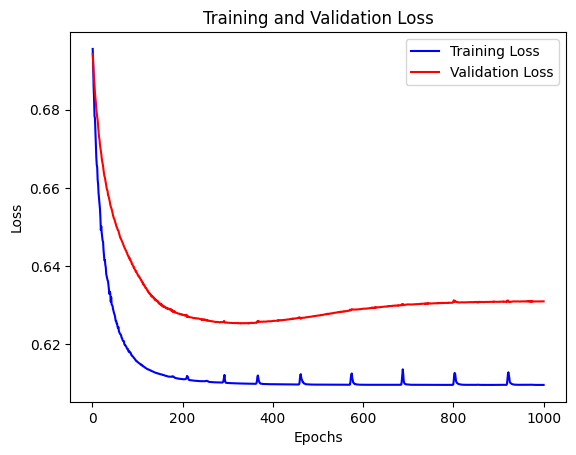

In [ ]:
import matplotlib.pyplot as plt

def plot_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Assuming 'history' is the returned history object from the model training
plot_loss(history)

In [ ]:
model, history, final_accuracy = collaborative_filtering_recommender(places_data, user_rating_data, 50, 8, 100, save_model_path='model')

Epoch 1/100
100/100 [==============================] - 5s 24ms/step - loss: 0.6969 - root_mean_squared_error: 0.1959 - val_loss: 0.6909 - val_root_mean_squared_error: 0.1883
Epoch 2/100
100/100 [==============================] - 1s 7ms/step - loss: 0.6907 - root_mean_squared_error: 0.1879 - val_loss: 0.6900 - val_root_mean_squared_error: 0.1871
Epoch 3/100
100/100 [==============================] - 1s 6ms/step - loss: 0.6889 - root_mean_squared_error: 0.1855 - val_loss: 0.6882 - val_root_mean_squared_error: 0.1848
Epoch 4/100
100/100 [==============================] - 1s 6ms/step - loss: 0.6845 - root_mean_squared_error: 0.1796 - val_loss: 0.6865 - val_root_mean_squared_error: 0.1824
Epoch 5/100
100/100 [==============================] - 1s 8ms/step - loss: 0.6807 - root_mean_squared_error: 0.1742 - val_loss: 0.6857 - val_root_mean_squared_error: 0.1813
Epoch 6/100
100/100 [==============================] - 1s 10ms/step - loss: 0.6781 - root_mean_squared_error: 0.1705 - val_loss: 0.684

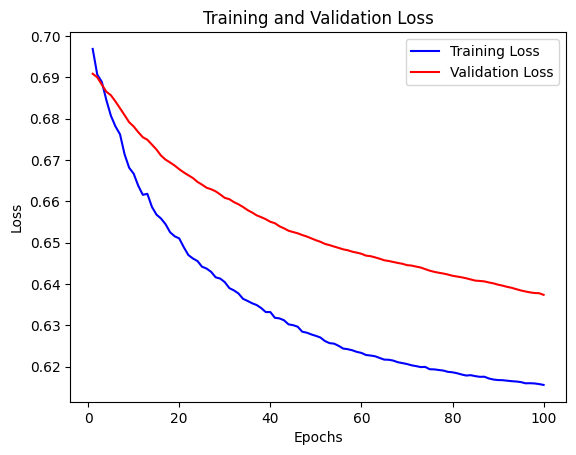

In [ ]:
import matplotlib.pyplot as plt

def plot_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Assuming 'history' is the returned history object from the model training
plot_loss(history)

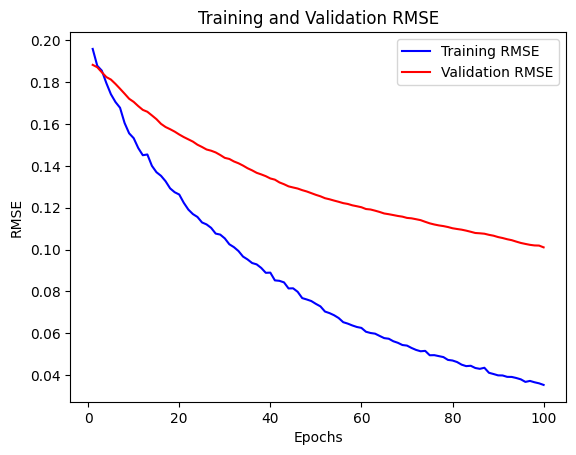

In [ ]:
import matplotlib.pyplot as plt

def plot_loss(history):
    loss = history.history['root_mean_squared_error']
    val_loss = history.history['val_root_mean_squared_error']
    epochs = range(1, len(loss) + 1)

    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training RMSE')
    plt.plot(epochs, val_loss, 'r', label='Validation RMSE')
    plt.title('Training and Validation RMSE')
    plt.xlabel('Epochs')
    plt.ylabel('RMSE')
    plt.legend()
    plt.show()

# Assuming 'history' is the returned history object from the model training
plot_loss(history)

In [ ]:
model.summary()

Model: "recommender_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  15000     
                                                                 
 embedding_1 (Embedding)     multiple                  300       
                                                                 
 embedding_2 (Embedding)     multiple                  14400     
                                                                 
 embedding_3 (Embedding)     multiple                  288       
                                                                 
Total params: 29988 (117.14 KB)
Trainable params: 29988 (117.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
layer_configs = []

# Iterate over the layers in the model and retrieve their configurations
for layer in model.layers:
    layer_configs.append(layer.get_config())

# Display the layer configurations
for config in layer_configs:
    print(config)

{'name': 'embedding', 'trainable': True, 'dtype': 'float32', 'batch_input_shape': (None, None), 'input_dim': 300, 'output_dim': 50, 'embeddings_initializer': {'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}, 'embeddings_regularizer': {'module': 'keras.regularizers', 'class_name': 'L2', 'config': {'l2': 9.999999974752427e-07}, 'registered_name': None}, 'activity_regularizer': None, 'embeddings_constraint': None, 'mask_zero': False, 'input_length': None}
{'name': 'embedding_1', 'trainable': True, 'dtype': 'float32', 'batch_input_shape': (None, None), 'input_dim': 300, 'output_dim': 1, 'embeddings_initializer': {'module': 'keras.initializers', 'class_name': 'RandomUniform', 'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None}, 'registered_name': None}, 'embeddings_regularizer': None, 'activity_regularizer': None, 'embeddings_constraint': None, 'mask_zero': False, 'input_length': None}
{'name': 'embedding_2', 'trainable': Tr

In [ ]:
import pandas as pd

layer_configs = []

# Iterate over the layers in the model and retrieve their configurations
for layer in model.layers:
    layer_configs.append(layer.get_config())

# Create a DataFrame from the layer configurations
df = pd.DataFrame(layer_configs)

# Display the DataFrame
df

,name,trainable,dtype,batch_input_shape,input_dim,output_dim,embeddings_initializer,embeddings_regularizer,activity_regularizer,embeddings_constraint,mask_zero,input_length
0,embedding,True,float32,"(None, None)",300,50,"{'module': 'keras.initializers', 'class_name':...","{'module': 'keras.regularizers', 'class_name':...",None,None,False,None
1,embedding_1,True,float32,"(None, None)",300,1,"{'module': 'keras.initializers', 'class_name':...",None,None,None,False,None
2,embedding_2,True,float32,"(None, None)",288,50,"{'module': 'keras.initializers', 'class_name':...","{'module': 'keras.regularizers', 'class_name':...",None,None,False,None
3,embedding_3,True,float32,"(None, None)",288,1,"{'module': 'keras.initializers', 'class_name':...",None,None,None,False,None


In [ ]:
model_1, history_1, final_accuracy_1 = collaborative_filtering_recommender(places_data, user_rating_data, 50, 8, 10, save_model_path='model')

Epoch 1/10
100/100 [==============================] - 2s 8ms/step - loss: 0.6938 - root_mean_squared_error: 0.1919 - val_loss: 0.6920 - val_root_mean_squared_error: 0.1897
Epoch 2/10
100/100 [==============================] - 0s 3ms/step - loss: 0.6899 - root_mean_squared_error: 0.1869 - val_loss: 0.6900 - val_root_mean_squared_error: 0.1871
Epoch 3/10
100/100 [==============================] - 0s 3ms/step - loss: 0.6866 - root_mean_squared_error: 0.1824 - val_loss: 0.6881 - val_root_mean_squared_error: 0.1846
Epoch 4/10
100/100 [==============================] - 0s 3ms/step - loss: 0.6820 - root_mean_squared_error: 0.1761 - val_loss: 0.6862 - val_root_mean_squared_error: 0.1820
Epoch 5/10
100/100 [==============================] - 0s 3ms/step - loss: 0.6811 - root_mean_squared_error: 0.1748 - val_loss: 0.6850 - val_root_mean_squared_error: 0.1803
Epoch 6/10
100/100 [==============================] - 0s 4ms/step - loss: 0.6768 - root_mean_squared_error: 0.1686 - val_loss: 0.6833 - val_

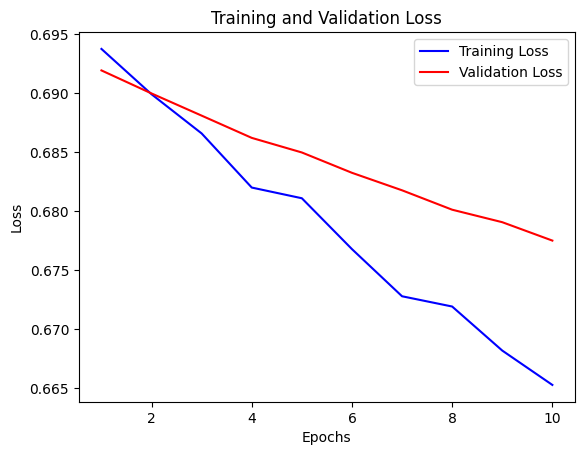

In [ ]:
import matplotlib.pyplot as plt

def plot_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Assuming 'history' is the returned history object from the model training
plot_loss(history_1)

In [ ]:
def recommend_by_collaborative_filtering(model, places_data, user_rating_data, user_id):
    resto_df = places_data
    df = user_rating_data
    resto_visited_by_user = df[df.ID_user == user_id]
    resto_not_visited = resto_df[~resto_df['Place_ID'].isin(resto_visited_by_user.Place_ID.values)]['Place_ID']
    resto_not_visited = list(
        set(resto_not_visited).intersection(resto_to_resto_encoded.keys())
    )
    resto_not_visited = list(map(resto_to_resto_encoded.get, resto_not_visited))

    user_encoder = user_to_user_encoded[user_id]
    user_resto_array = np.hstack(([[user_encoder]] * len(resto_not_visited), np.array(resto_not_visited)[:, None]))
    ratings = model.predict(user_resto_array).flatten()
    top_ratings_indices = ratings.argsort()[-25:][::-1]
    recommended_resto_ids = [resto_encoded_to_resto.get(resto_not_visited[index]) for index in top_ratings_indices]
    recommended_resto_info = resto_df[resto_df['Place_ID'].isin(recommended_resto_ids)][['Place_Name', 'Latitude', 'Longitude', 'Place_Category']].values.tolist()

    recommended_places = {
        'Nama Tempat': [],
        'Latitude': [],
        'Longitude': [],
        'Kategori' : []
    }

    for place_info in recommended_resto_info:
        recommended_places['Nama Tempat'].append(place_info[0])
        recommended_places['Latitude'].append(place_info[1])
        recommended_places['Longitude'].append(place_info[2])
        recommended_places['Kategori'].append(place_info[3])

    return recommended_places

In [ ]:
def haversine_distance(coord1, coord2):
    # Calculate the distance using Haversine formula
    return geodesic(coord1, coord2).kilometers

def find_closest_place(current_place, places_data, valid_categories):
    current_coord = (places_data['Latitude'][current_place], places_data['Longitude'][current_place])
    valid_places = [(i, (places_data['Latitude'][i], places_data['Longitude'][i])) for i in range(len(places_data['Nama Tempat']))
                    if places_data['Kategori'][i] in valid_categories and i != current_place]
    if not valid_places:
        return None
    closest_place, closest_distance = min(valid_places, key=lambda x: haversine_distance(current_coord, x[1]))
    return closest_place

def generate_rundown_for_user(user_data):
    places_data = {
        'Nama Tempat': user_data['Nama Tempat'],
        'Latitude': user_data['Latitude'],
        'Longitude': user_data['Longitude'],
        'Kategori': user_data['Kategori']
    }

    # Find the first accommodation place
    accommodation_place = user_data['Kategori'].index('Accomodation')

    # 9 PM - 6 AM: Accommodation
    rundown = {'9 PM - 6 AM': [places_data['Nama Tempat'][accommodation_place]]}

    # 6 AM - 8 AM: Culinary (Breakfast)
    culinary_place = find_closest_place(accommodation_place, places_data, ['Culinary'])
    rundown['6 AM - 8 AM'] = [places_data['Nama Tempat'][culinary_place]]

    # 8 AM - 10 AM: Activity
    valid_activity_categories = ['Nautical', 'Nature', 'History', 'Entertainment', 'Shopping', 'Art']
    activity_place = find_closest_place(culinary_place, places_data, valid_activity_categories)
    rundown['8 AM - 10 AM'] = [places_data['Nama Tempat'][activity_place]]

    # 10 AM - 12 PM: Activity
    valid_activity_categories_10_to_12 = ['Nautical', 'Nature', 'History', 'Entertainment', 'Shopping', 'Art']
    activity_place_10_to_12 = find_closest_place(activity_place, places_data, valid_activity_categories_10_to_12)
    rundown['10 AM - 12 PM'] = [places_data['Nama Tempat'][activity_place_10_to_12]]

    # 12 PM - 1 PM: Culinary (Lunch)
    culinary_place_12_to_1 = find_closest_place(activity_place_10_to_12, places_data, ['Culinary'])
    rundown['12 PM - 1 PM'] = [places_data['Nama Tempat'][culinary_place_12_to_1]]

    # 1 PM - 3 PM: Activity
    valid_activity_categories_1_to_3 = ['Nautical', 'Nature', 'History', 'Entertainment', 'Shopping', 'Art']
    activity_place_1_to_3 = find_closest_place(culinary_place_12_to_1, places_data, valid_activity_categories_1_to_3)
    rundown['1 PM - 3 PM'] = [places_data['Nama Tempat'][activity_place_1_to_3]]

    # 3 PM - 5 PM: Activity
    valid_activity_categories_3_to_5 = ['Nautical', 'Nature', 'History', 'Entertainment', 'Shopping', 'Art']
    activity_place_3_to_5 = find_closest_place(activity_place_1_to_3, places_data, valid_activity_categories_3_to_5)
    rundown['3 PM - 5 PM'] = [places_data['Nama Tempat'][activity_place_3_to_5]]

    # 5 PM - 7 PM: Culinary (Dinner)
    culinary_place_5_to_7 = find_closest_place(activity_place_3_to_5, places_data, ['Culinary'])
    rundown['5 PM - 7 PM'] = [places_data['Nama Tempat'][culinary_place_5_to_7]]

    # 7 PM - 9 PM: Shopping
    shopping_place_7_to_9 = find_closest_place(culinary_place_5_to_7, places_data, ['Shopping'])
    rundown['7 PM - 9 PM'] = [places_data['Nama Tempat'][shopping_place_7_to_9]]

    return rundown


In [ ]:
save_model_path = 'model'  # Replace with the desired save path
recommender = collaborative_filtering_recommender(places_data, user_rating_data, embedding_size=50, batch_size=8, epochs=10, save_model_path=save_model_path)

Epoch 1/10
100/100 [==============================] - 1s 4ms/step - loss: 0.6957 - root_mean_squared_error: 0.1943 - val_loss: 0.6941 - val_root_mean_squared_error: 0.1925
Epoch 2/10
100/100 [==============================] - 0s 3ms/step - loss: 0.6910 - root_mean_squared_error: 0.1883 - val_loss: 0.6920 - val_root_mean_squared_error: 0.1897
Epoch 3/10
100/100 [==============================] - 0s 3ms/step - loss: 0.6868 - root_mean_squared_error: 0.1827 - val_loss: 0.6901 - val_root_mean_squared_error: 0.1872
Epoch 4/10
100/100 [==============================] - 0s 3ms/step - loss: 0.6828 - root_mean_squared_error: 0.1771 - val_loss: 0.6884 - val_root_mean_squared_error: 0.1849
Epoch 5/10
100/100 [==============================] - 0s 3ms/step - loss: 0.6811 - root_mean_squared_error: 0.1748 - val_loss: 0.6871 - val_root_mean_squared_error: 0.1833
Epoch 6/10
100/100 [==============================] - 0s 3ms/step - loss: 0.6785 - root_mean_squared_error: 0.1712 - val_loss: 0.6850 - val_

In [ ]:
user_id = 12 # Replace 123 with the actual user ID
recommendations = recommend_by_collaborative_filtering(recommender, places_data, user_rating_data, user_id)

9/9 [==============================] - 0s 3ms/step


In [ ]:
recommendations

{'Nama Tempat': ['Corner House Bali',
  'The Menjangan Resort Bali',
  'Cuca Flavor',
  'Babi Guling Pak Malen',
  'The St. Regis Bali Resort',
  'Sekumpul Waterfall',
  'Menjangan Island',
  'West Bali National Park',
  'Pura Ulun Danu Bratan',
  'Aling-Aling Waterfall',
  'Pura Beji Sangsit',
  'Krisna Water Sports',
  'Tamblingan Jungle Swing',
  'Melka Excelsior Dolphin & Wildlife Resort',
  'Pura Dalem Desa Adat Jagaraga',
  'Tanah Lot',
  'Uluwatu Temple',
  'Garuda Wisnu Kencana (GWK)',
  'Pura Luhur Batukaru',
  'Pandawa Beach',
  'Jimbaran Bay',
  'Seminyak',
  'Nusa Dua',
  'Waterbom Bali',
  'Sanur'],
 'Latitude': [-8.7223,
  -8.1434,
  -8.77254,
  -8.6848,
  -8.8129,
  -8.1782107,
  -8.09601895,
  -8.16723015,
  -8.27492588,
  -8.1767917,
  -8.08358264,
  -8.18047747,
  -8.26309387,
  -8.1464049,
  -8.5094868,
  -8.62122865,
  -8.82924075,
  -8.8089465,
  -8.3726461,
  -8.84580465,
  -8.7833785,
  -8.6908357,
  -8.8016122,
  -8.72829275,
  -8.6831728],
 'Longitude': [115.17

In [ ]:
df_rec = pd.DataFrame(recommendations)
df_rec

,Nama Tempat,Latitude,Longitude,Kategori
0,Corner House Bali,-8.722300,115.175700,Culinary
1,The Menjangan Resort Bali,-8.143400,114.546900,Culinary
2,Cuca Flavor,-8.772540,115.169800,Culinary
3,Babi Guling Pak Malen,-8.684800,115.169100,Culinary
4,The St. Regis Bali Resort,-8.812900,115.227600,Accomodation
5,Sekumpul Waterfall,-8.178211,115.182752,Nature
6,Menjangan Island,-8.096019,114.517796,Nautical
7,West Bali National Park,-8.167230,114.462695,Nature
8,Pura Ulun Danu Bratan,-8.274926,115.166813,History
9,Aling-Aling Waterfall,-8.176792,115.106284,Nature


In [ ]:
from geopy.distance import geodesic

def haversine_distance(coord1, coord2):
    # Calculate the distance using the Haversine formula
    return geodesic(coord1, coord2).kilometers

def find_closest_place(current_place, places_data, valid_categories):
    current_coord = (places_data['Latitude'][current_place], places_data['Longitude'][current_place])
    valid_places = [(i, (places_data['Latitude'][i], places_data['Longitude'][i])) for i in range(len(places_data['Nama Tempat']))
                    if places_data['Kategori'][i] in valid_categories and i != current_place]
    if not valid_places:
        return None
    closest_place, closest_distance = min(valid_places, key=lambda x: haversine_distance(current_coord, x[1]))
    return closest_place

def delete_processed_place(places_data, index):
    del places_data['Nama Tempat'][index]
    del places_data['Latitude'][index]
    del places_data['Longitude'][index]
    del places_data['Kategori'][index]

def generate_rundown_for_user(user_data):
    places_data = {
        'Nama Tempat': user_data['Nama Tempat'],
        'Latitude': user_data['Latitude'],
        'Longitude': user_data['Longitude'],
        'Kategori': user_data['Kategori']
    }

    # Find the first accommodation place
    accommodation_place = user_data['Kategori'].index('Accomodation')

    # 9 PM - 6 AM: Accommodation
    rundown = [{'Jam Rundown': '9 PM - 6 AM',
                'Nama Tempat': places_data['Nama Tempat'][accommodation_place],
                'Kategori': places_data['Kategori'][accommodation_place],
                'Jarak Tempat': None}]
    delete_processed_place(places_data, accommodation_place)

    # 6 AM - 8 AM: Culinary (Breakfast)
    culinary_place = find_closest_place(accommodation_place, places_data, ['Culinary'])
    distance = haversine_distance((places_data['Latitude'][accommodation_place], places_data['Longitude'][accommodation_place]),
                                  (places_data['Latitude'][culinary_place], places_data['Longitude'][culinary_place]))
    rundown.append({'Jam Rundown': '6 AM - 8 AM',
                    'Nama Tempat': places_data['Nama Tempat'][culinary_place],
                    'Kategori': places_data['Kategori'][culinary_place],
                    'Jarak Tempat': distance})
    delete_processed_place(places_data, culinary_place)

    # 8 AM - 10 AM: Activity
    valid_activity_categories = ['Nautical', 'Nature', 'History', 'Entertainment', 'Shopping', 'Art']
    activity_place = find_closest_place(culinary_place, places_data, valid_activity_categories)
    distance = haversine_distance((places_data['Latitude'][culinary_place], places_data['Longitude'][culinary_place]),
                                  (places_data['Latitude'][activity_place], places_data['Longitude'][activity_place]))
    rundown.append({'Jam Rundown': '8 AM - 10 AM',
                    'Nama Tempat': places_data['Nama Tempat'][activity_place],
                    'Kategori': places_data['Kategori'][activity_place],
                    'Jarak Tempat': distance})
    delete_processed_place(places_data, activity_place)

    # 10 AM - 12 PM: Activity
    valid_activity_categories_10_to_12 = ['Nautical', 'Nature', 'History', 'Entertainment', 'Shopping', 'Art']
    activity_place_10_to_12 = find_closest_place(activity_place, places_data, valid_activity_categories_10_to_12)
    distance = haversine_distance((places_data['Latitude'][activity_place], places_data['Longitude'][activity_place]),
                                  (places_data['Latitude'][activity_place_10_to_12], places_data['Longitude'][activity_place_10_to_12]))
    rundown.append({'Jam Rundown': '10 AM - 12 PM',
                    'Nama Tempat': places_data['Nama Tempat'][activity_place_10_to_12],
                    'Kategori': places_data['Kategori'][activity_place_10_to_12],
                    'Jarak Tempat': distance})
    delete_processed_place(places_data, activity_place_10_to_12)

    # 12 PM - 1 PM: Culinary (Lunch)
    culinary_place_12_to_1 = find_closest_place(activity_place_10_to_12, places_data, ['Culinary'])
    distance = haversine_distance((places_data['Latitude'][activity_place_10_to_12], places_data['Longitude'][activity_place_10_to_12]),
                                  (places_data['Latitude'][culinary_place_12_to_1], places_data['Longitude'][culinary_place_12_to_1]))
    rundown.append({'Jam Rundown': '12 PM - 1 PM',
                    'Nama Tempat': places_data['Nama Tempat'][culinary_place_12_to_1],
                    'Kategori': places_data['Kategori'][culinary_place_12_to_1],
                    'Jarak Tempat': distance})
    delete_processed_place(places_data, culinary_place_12_to_1)

    # 1 PM - 3 PM: Activity
    valid_activity_categories_1_to_3 = ['Nautical', 'Nature', 'History', 'Entertainment', 'Shopping', 'Art']
    activity_place_1_to_3 = find_closest_place(culinary_place_12_to_1, places_data, valid_activity_categories_1_to_3)
    distance = haversine_distance((places_data['Latitude'][culinary_place_12_to_1], places_data['Longitude'][culinary_place_12_to_1]),
                                  (places_data['Latitude'][activity_place_1_to_3], places_data['Longitude'][activity_place_1_to_3]))
    rundown.append({'Jam Rundown': '1 PM - 3 PM',
                    'Nama Tempat': places_data['Nama Tempat'][activity_place_1_to_3],
                    'Kategori': places_data['Kategori'][activity_place_1_to_3],
                    'Jarak Tempat': distance})
    delete_processed_place(places_data, activity_place_1_to_3)

    # 3 PM - 5 PM: Activity
    valid_activity_categories_3_to_5 = ['Nautical', 'Nature', 'History', 'Entertainment', 'Shopping', 'Art']
    activity_place_3_to_5 = find_closest_place(activity_place_1_to_3, places_data, valid_activity_categories_3_to_5)
    distance = haversine_distance((places_data['Latitude'][activity_place_1_to_3], places_data['Longitude'][activity_place_1_to_3]),
                                  (places_data['Latitude'][activity_place_3_to_5], places_data['Longitude'][activity_place_3_to_5]))
    rundown.append({'Jam Rundown': '3 PM - 5 PM',
                    'Nama Tempat': places_data['Nama Tempat'][activity_place_3_to_5],
                    'Kategori': places_data['Kategori'][activity_place_3_to_5],
                    'Jarak Tempat': distance})
    delete_processed_place(places_data, activity_place_3_to_5)

    # 5 PM - 7 PM: Culinary (Dinner)
    culinary_place_5_to_7 = find_closest_place(activity_place_3_to_5, places_data, ['Culinary'])
    distance = haversine_distance((places_data['Latitude'][activity_place_3_to_5], places_data['Longitude'][activity_place_3_to_5]),
                                  (places_data['Latitude'][culinary_place_5_to_7], places_data['Longitude'][culinary_place_5_to_7]))
    rundown.append({'Jam Rundown': '5 PM - 7 PM',
                    'Nama Tempat': places_data['Nama Tempat'][culinary_place_5_to_7],
                    'Kategori': places_data['Kategori'][culinary_place_5_to_7],
                    'Jarak Tempat': distance})
    delete_processed_place(places_data, culinary_place_5_to_7)

    # 7 PM - 9 PM: Shopping
    shopping_place_7_to_9 = find_closest_place(culinary_place_5_to_7, places_data, ['Shopping'])
    distance = haversine_distance((places_data['Latitude'][culinary_place_5_to_7], places_data['Longitude'][culinary_place_5_to_7]),
                                  (places_data['Latitude'][shopping_place_7_to_9], places_data['Longitude'][shopping_place_7_to_9]))
    rundown.append({'Jam Rundown': '7 PM - 9 PM',
                    'Nama Tempat': places_data['Nama Tempat'][shopping_place_7_to_9],
                    'Kategori': places_data['Kategori'][shopping_place_7_to_9],
                    'Jarak Tempat': distance})
    delete_processed_place(places_data, shopping_place_7_to_9)

    return rundown

In [ ]:
rundown1 = generate_rundown_for_user(recommendations)
rundown1

[{'Jam Rundown': '9 PM - 6 AM',
  'Nama Tempat': 'The St. Regis Bali Resort',
  'Kategori': 'Accomodation',
  'Jarak Tempat': None},
 {'Jam Rundown': '6 AM - 8 AM',
  'Nama Tempat': 'Babi Guling Pak Malen',
  'Kategori': 'Culinary',
  'Jarak Tempat': 56.04801092731568},
 {'Jam Rundown': '8 AM - 10 AM',
  'Nama Tempat': 'Aling-Aling Waterfall',
  'Kategori': 'Nature',
  'Jarak Tempat': 8.427825234109033},
 {'Jam Rundown': '10 AM - 12 PM',
  'Nama Tempat': 'Sekumpul Waterfall',
  'Kategori': 'Nature',
  'Jarak Tempat': 11.75199371221241},
 {'Jam Rundown': '12 PM - 1 PM',
  'Nama Tempat': 'The Menjangan Resort Bali',
  'Kategori': 'Culinary',
  'Jarak Tempat': 6.143916077764508},
 {'Jam Rundown': '1 PM - 3 PM',
  'Nama Tempat': 'Jimbaran Bay',
  'Kategori': 'Nautical',
  'Jarak Tempat': 1.655924823734593},
 {'Jam Rundown': '3 PM - 5 PM',
  'Nama Tempat': 'Waterbom Bali',
  'Kategori': 'Entertainment',
  'Jarak Tempat': 4.202735587182757},
 {'Jam Rundown': '5 PM - 7 PM',
  'Nama Tempat': '

# Start Point

**East Bali:**
*   Latitude: Approximately -8.471148
*   Longitude: Approximately 115.665717

**North Bali:**
*   Latitude: Approximately -8.182740
*   Longitude: Approximately 115.136624

**West Bali:**
*   Latitude: Approximately -8.409518
*   Longitude: Approximately 114.979448

**South Bali:**
*   Latitude: Approximately -8.409518
*   Longitude: Approximately 115.188916

In [ ]:
places_data

,Place_ID,Place_Name,Place_Location,Place_Region,Place_Price,Place_Rating,Place_Opening_Hours,Latitude,Longitude,Place_Category,Locate_URL
0,1,Warung Babi Guling Pak Malen,"Gianyar, Bali, Indonesia",East Bali,50000,4.6,10:00 AM – 8:00 PM,-8.684800,115.169100,Culinary,https://maps.app.goo.gl/UUumvGccvaaE8h9G7
1,2,Warung Mak Beng,"Sanur, Denpasar, Bali, Indonesia",East Bali,40000,4.5,9:00 AM – 5:00 PM,-8.673780,115.263000,Culinary,https://maps.app.goo.gl/dZPoYLe5pGxKdTDg6
2,3,Ibu Oka Babi Guling,"Ubud, Gianyar, Bali, Indonesia",East Bali,50000,4.1,11:00 AM - 6:00 PM,-8.505770,115.264300,Culinary,https://maps.app.goo.gl/x1dkkdQ1dxGRz1An7
3,4,Bebek Tepi Sawah Restaurant,"Ubud, Gianyar, Bali, Indonesia",East Bali,150000,4.5,10:00 AM – 10:00 PM,-8.671980,115.165000,Culinary,https://maps.app.goo.gl/ZQM7Pxw2sdUxzrWA9
4,5,Locavore,"Ubud, Gianyar, Bali, Indonesia",East Bali,790000,4.8,"12:00 PM – 2:00 PM, 6:00 PM – 9:00 PM",-8.509960,115.263500,Culinary,https://maps.app.goo.gl/F2ttTG6qYiUBXhZE6
...,...,...,...,...,...,...,...,...,...,...,...
295,296,Pulaki Junction,"Banyupoh, Gerokgak, Buleleng Regency, Bali, I...",West Bali,0,4.4,Open 24 hours,-8.145392,114.680376,Nautical,https://maps.app.goo.gl/vwDLw2TEgzbdKNPQ8
296,297,Banyuwedang Hotspring Water,"Banyuwedang, Gerokgak, Buleleng Regency, Bali...",West Bali,20000,4.4,8:00 AM – 6:00 PM,-8.139069,114.570685,Nature,https://maps.app.goo.gl/ooW1S37QeLgyjk879
297,298,Palasari Dam Terrace,"Palasari, Melaya, Jembrana Regency, Bali, Ind...",West Bali,0,4.3,Open 24 hours,-8.253173,114.550714,Nature,https://maps.app.goo.gl/DgWdxygdga5e1diZA
298,299,Delodberawah Rice Terrace,"Jembrana Regency, Bali, Indonesia",West Bali,0,4.4,Open 24 hours,-8.394918,114.675567,Nature,https://maps.app.goo.gl/F3VVYCYbbVbs6uFz9


# Drafts

In [ ]:
def create_rundown(output_data):
    rundown = {
        '9 PM - 6 AM': [],
        '7 AM - 8 AM': [],
        '8 AM - 10 AM': [],
        '10 AM - 12 PM': [],
        '12 PM - 1 PM': [],
        '1 PM - 3 PM': [],
        '3 PM - 5 PM': [],
        '5 PM - 7 PM': [],
        '7 PM - 9 PM': []
    }

    for i in range(len(output_data['Nama Tempat'])):
        category = output_data['Kategori'][i]
        place = output_data['Nama Tempat'][i]

        if category == 'Accommodation':
            rundown['9 PM - 6 AM'].append(place)
        elif category == 'Culinary':
            if i % 2 == 0:
                rundown['7 AM - 8 AM'].append(place)
            else:
                rundown['12 PM - 1 PM'].append(place)
                rundown['5 PM - 7 PM'].append(place)
        else:
            rundown['8 AM - 10 AM'].append(place)
            rundown['10 AM - 12 PM'].append(place)
            rundown['1 PM - 3 PM'].append(place)
            rundown['3 PM - 5 PM'].append(place)
            rundown['7 PM - 9 PM'].append(place)

    return rundown

In [ ]:
def create_rundown(output_data):
    categories = ['Culinary', 'Accommodation', 'Nautical', 'Nature', 'History', 'Entertainment', 'Shopping', 'Art']
    time_intervals = ['9 PM - 6 AM', '7 AM - 8 AM', '8 AM - 10 AM', '10 AM - 12 PM', '12 PM - 1 PM', '1 PM - 3 PM', '3 PM - 5 PM', '5 PM - 7 PM', '7 PM - 9 PM']

    # Create a dictionary to store the locations for each time interval
    rundown = {interval: [] for interval in time_intervals}

    for i in range(len(output_data['Nama Tempat'])):
        place = output_data['Nama Tempat'][i]
        category = output_data['Kategori'][i]
        latitude = output_data['Latitude'][i]
        longitude = output_data['Longitude'][i]

        # Find the appropriate time interval based on the category
        if category == 'Accomodation':
            interval = '9 PM - 6 AM'
        elif category == 'Culinary':
            if i % 2 == 0:
                interval = '7 AM - 8 AM'
            else:
                interval = '12 PM - 1 PM'
        else:
            if i % 4 == 0:
                interval = '8 AM - 10 AM'
            elif i % 3 == 0:
                interval = '10 AM - 12 PM'
            elif i % 5 == 0:
                interval = '1 PM - 3 PM'
            elif i % 6 == 0:
                interval = '3 PM - 5 PM'
            else:
                interval = '5 PM - 7 PM'

        # Add the place and its coordinates to the corresponding time interval
        rundown[interval].append({'place': place, 'category': category, 'latitude': latitude, 'longitude': longitude})

    return rundown

In [ ]:
def create_rundown(output_data):
    categories = ['Culinary', 'Accommodation', 'Nautical', 'Nature', 'History', 'Entertainment', 'Shopping', 'Art']
    time_intervals = ['9 PM - 6 AM', '7 AM - 8 AM', '8 AM - 10 AM', '10 AM - 12 PM', '12 PM - 1 PM', '1 PM - 3 PM', '3 PM - 5 PM', '5 PM - 7 PM', '7 PM - 9 PM']

    # Create a dictionary to store the locations for each time interval
    rundown = {interval: [] for interval in time_intervals}

    for i in range(len(output_data['Nama Tempat'])):
        place = output_data['Nama Tempat'][i]
        category = output_data['Kategori'][i]
        latitude = output_data['Latitude'][i]
        longitude = output_data['Longitude'][i]

        # Find the appropriate time interval based on the category
        if category == 'Accomodation':
            interval = '9 PM - 6 AM'
        elif category == 'Culinary':
                interval = '7 AM - 8 AM' or '12 PM - 1 PM' or '5 PM - 7 PM'
        else:
            if category == "Nautical" or "Nature" or "History" or "Entertainment" or "Shopping" or "Art":
                interval = '8 AM - 10 AM' or '10 AM - 12 PM' or '1 PM - 3 PM' or '3 PM - 5 PM'
            if category == "Shopping":
              interval = '7 PM - 9 PM'

        # Add the place and its coordinates to the corresponding time interval
        rundown[interval].append({'place': place, 'category': category, 'latitude': latitude, 'longitude': longitude})

    return rundown

In [ ]:
def create_rundown(output_data):
    categories = ['Culinary', 'Accommodation', 'Nautical', 'Nature', 'History', 'Entertainment', 'Shopping', 'Art']
    time_intervals = ['9 PM - 6 AM', '6 AM - 8 AM', '8 AM - 10 AM', '10 AM - 12 PM', '12 PM - 1 PM', '1 PM - 3 PM', '3 PM - 5 PM', '5 PM - 7 PM', '7 PM - 9 PM']

    # Create a dictionary to store the locations for each time interval
    rundown = {interval: [] for interval in time_intervals}

    for i in range(len(output_data['Nama Tempat'])):
        place = output_data['Nama Tempat'][i]
        category = output_data['Kategori'][i]
        latitude = output_data['Latitude'][i]
        longitude = output_data['Longitude'][i]

        # Find the appropriate time interval based on the category
        if category == 'Accomodation':
            interval = '9 PM - 6 AM'
        elif category == 'Culinary' and any(interval in ['6 AM - 8 AM', '12 PM - 1 PM', '5 PM - 7 PM'] for interval in time_intervals):
            interval = '6 AM - 8 AM' if '7 AM - 8 AM' in time_intervals else '12 PM - 1 PM' if '12 PM - 1 PM' in time_intervals else '5 PM - 7 PM'
        elif category in ["Nautical", "Nature", "History", "Entertainment", "Shopping", "Art"] and any(interval in ['8 AM - 10 AM', '10 AM - 12 PM', '1 PM - 3 PM', '3 PM - 5 PM'] for interval in time_intervals):
            interval = '8 AM - 10 AM' if '8 AM - 10 AM' in time_intervals else '10 AM - 12 PM' if '10 AM - 12 PM' in time_intervals else '1 PM - 3 PM' if '1 PM - 3 PM' in time_intervals else '3 PM - 5 PM'
        elif category == "Shopping" and '7 PM - 9 PM' in time_intervals:
            interval = '7 PM - 9 PM'
        else:
            interval = None

        # Add the place and its coordinates to the corresponding time interval
        if interval:
            rundown[interval].append({'place': place, 'category': category, 'latitude': latitude, 'longitude': longitude})

    return rundown


In [ ]:
import math

def calculate_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the distance between two points on the Earth's surface
    using the Haversine formula.
    """
    # Convert latitude and longitude from degrees to radians
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)

    # Radius of the Earth in kilometers
    radius = 6371

    # Haversine formula
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    a = math.sin(dlat / 2) ** 2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = radius * c

    return distance

def filter_by_closest_location(recommendations, start_lat, start_lon):
    """
    Filter the recommended places by the closest location to the start point.
    """
    filtered_recommendations = {}
    for time_interval, places in recommendations.items():
        closest_place = None
        closest_distance = float('inf')
        for place in places:
            distance = calculate_distance(start_lat, start_lon, place['latitude'], place['longitude'])
            if distance < closest_distance:
                closest_place = place
                closest_distance = distance
        if closest_place is not None:
            filtered_recommendations[time_interval] = [closest_place]

    return filtered_recommendations